In [18]:
import cv2
import os
import numpy as np 
from tqdm import tqdm
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import pickle
from pathlib import Path
import random
import plotly.express as px
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.utils.extmath import randomized_svd
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from PIL import Image
from sklearn.svm import SVC

In [2]:
random.seed(1126)

In [3]:
def load_data(dir_path, IMG_SIZE):
   
    X = []
    y = []
    i = 0
    labels = dict()
    #Loading images folder by folder
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            #Setting image label to the name of folder image is in
            labels[i] = path
            for file in os.listdir(dir_path +'/'+ path):
                if not file.startswith('.'):
                    #loading in each individual image
                    img = Image.open(dir_path + '/'+ path + '/' + file)
                    imagedat = np.array(img)
                    imagedat = imagedat.astype('float32') / 255
                    resized = cv2.resize(imagedat, IMG_SIZE, interpolation = cv2.INTER_AREA)
                    X.append(resized)
                    y.append(i)
            i += 1
    #Converting lists to np arrays
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [4]:
#function that takes in a dataset of images, their labels, a dictionary of their lables
# and a tuple containing a desired grid of image samples
def check_labels(dataset, y_labels, labels, sample_size = (3,5)):
    samples = np.random.randint(0, len(dataset), size=sample_size)
    fig, ax = plt.subplots(len(samples),len(samples[0]))
    for i in range(len(samples)):
        for j in range(len(samples[0])):
            ax[i,j].imshow(dataset[samples[i,j]], cmap='gray')
            ax[i,j].set_title(f'{labels[y_labels[samples[i,j]]]} Face')
            ax[i,j].axis('off')
            
            



In [5]:
def visualize_pca(dataset, ratio=.95):
   # shape = (len(dataset[0])*len(dataset[0,0]))
   # pcaprep = np.reshape(dataset, (len(dataset),shape))
    #running pca without components to capture all component data
    pca = PCA()
    pca.fit(dataset)
    #plotting components vs cumulative explained ratio
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    #making ratio line
    x = np.linspace(0, (len(dataset[0])), 100)
    y = ratio * np.ones_like(x)
    plt.plot(x, y, label=f'y = {ratio}')


In [6]:
def augment_images(dataset, tilt=20, flip=True, vshift=.20, hshift=.20):
    augmented_images = []
    for image in dataset:
        # Randomly flip the image horizontally or vertically
        if random.choice([0,1]) == 1:
            image = cv2.flip(image, 1)

        # Randomly rotate the image up to 20 degrees
        angle = random.uniform(-20, 20)
        rows, cols = image.shape
        rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
        image = cv2.warpAffine(image, rotation_matrix, (cols, rows))

        # Randomly shift horizontally or vertically
        tx = random.randint(-10, 10)
        ty = random.randint(-10, 10)
        translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])
        image = cv2.warpAffine(image, translation_matrix, (cols, rows))

        augmented_images.append(image)

    return np.array(augmented_images)

In [7]:
def apply_pca(dataset, ratio=.95, sample=True):
    #reshape image data into 2d array for pca imput
    shape = (len(dataset[0])*len(dataset[0,0]))
    pcaprep = np.reshape(dataset, (len(dataset),shape))
    #apply pca (default 95% of variance)
    pca = PCA(ratio)
    pca.fit(pcaprep)
    transform = pca.transform(pcaprep)
    if sample == True:
        fig, ax = plt.subplots(1,2)
        inverse = pca.inverse_transform(transform)
        ax[0].imshow(dataset[10], cmap = 'gray')
        ax[0].set_title("Original")
        ax[1].imshow(inverse[10].reshape(48,48), cmap='gray')
        ax[1].set_title("Transformed")
        
    return pca, transform

In [8]:
def getclasssamples(y, percent=.3):
    samples = np.empty_like(np.random.choice(np.argwhere(y==1).reshape(len(np.argwhere(y==1))), replace=False))
    for i in np.unique(y):
        labels = np.argwhere(y==i)
        num_samples = int(percent * len(labels))
        selected_indices = np.random.choice(labels.reshape(len(labels)), size=num_samples, replace=False)
        samples = np.append(samples,selected_indices)
    return samples

In [9]:
TRAIN_DIR = ('imagedata/Training/Training')
TEST_DIR = ('imagedata/Testing/Testing')

#creating output folder for pickles
OUTPUT_DIR = Path('output')
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

IMG_SIZE= (48, 48)

In [10]:
X_train, y_train, train_labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, test_labels = load_data(TEST_DIR,IMG_SIZE)

100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


28273 images loaded from imagedata/Training/Training directory.


100%|██████████| 7/7 [00:02<00:00,  2.49it/s]

7067 images loaded from imagedata/Testing/Testing directory.


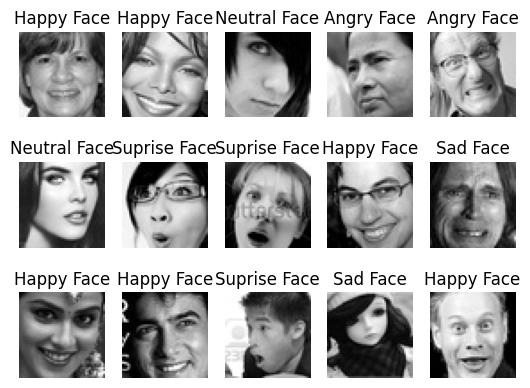

In [11]:
check_labels(X_train, y_train, train_labels)

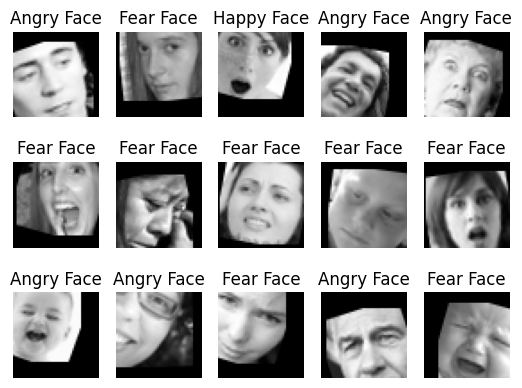

In [13]:
augmentindicies = getclasssamples(y_train)
X_augmented = augment_images(X_train[augmentindicies])
check_labels(X_augmented, y_train, train_labels)

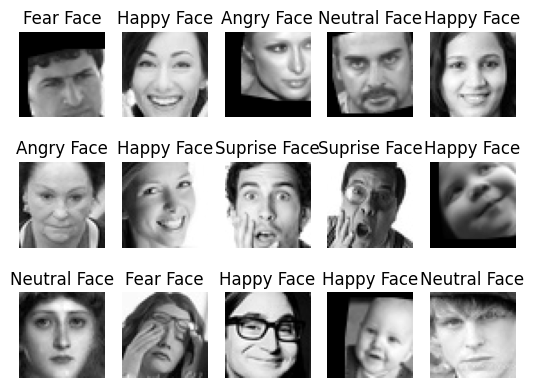

In [21]:
X_fulltrain = np.concatenate((X_train, X_augmented), axis=0)
y_fulltrain = np.concatenate((y_train, y_train[augmentindicies]), axis=0)
check_labels(X_fulltrain, y_fulltrain, train_labels)

In [22]:
scaler = StandardScaler()
scaledtrain = scaler.fit_transform(X_fulltrain.reshape(len(X_fulltrain), 48*48))

In [23]:
scaledtrain.shape

(36754, 2304)

(PCA(n_components=0.95),
 array([[  8.602806  ,  -4.329569  ,  -3.5232189 , ...,  -0.03722616,
           0.19102573,   0.20294909],
        [  0.8577342 ,   3.9813972 ,   5.4646325 , ...,   0.0741027 ,
           0.30895975,  -0.49945098],
        [  2.6124363 ,  -5.337474  ,   1.9832494 , ...,  -0.01599117,
           0.11259322,  -0.14836308],
        ...,
        [ -1.4494584 ,   7.3724823 ,  -5.4792776 , ...,  -0.22039355,
          -0.13522226,  -0.05056834],
        [-10.790319  ,   4.166011  ,  -2.3671203 , ...,  -0.04098563,
          -0.18928772,   0.12858397],
        [  0.2884478 ,   2.5489078 ,  -3.1649919 , ...,   0.07679723,
           0.14290556,   0.06832448]], dtype=float32))

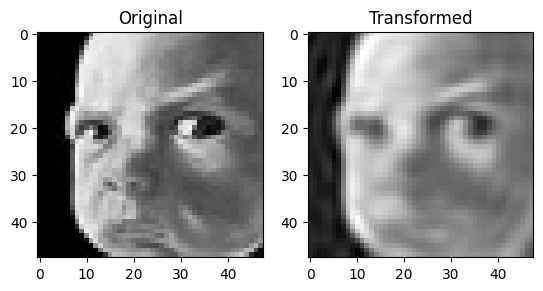

In [24]:
apply_pca(X_fulltrain, .95)

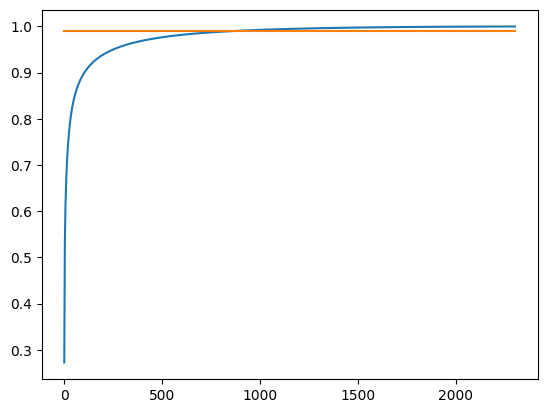

In [25]:
visualize_pca(scaledtrain, .99)

In [26]:
scalePCA = PCA(.99)
scalePCA.fit(scaledtrain)
transformedscaled = scalePCA.transform(scaledtrain)

In [27]:
transformedscaled.shape

(36754, 857)

In [28]:
48*48

2304

In [29]:
lda = LinearDiscriminantAnalysis()
ldascaledPCA = lda.fit_transform(transformedscaled, y_fulltrain)

In [30]:
testscale = scaler.transform(X_test.reshape(len(X_test),48*48))
testpca = scalePCA.transform(testscale)
testdata = lda.transform(testpca)

In [31]:
model_train_labels = [train_labels[i] for i in y_fulltrain]
model_test_labels = [test_labels[i] for i in y_test]

In [20]:
param_grid = {
    'alpha': [0.0001, 0.001, 0.01],
    'loss': ['hinge', 'log_loss', 'modified_huber'],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'max_iter': [1000, 2000, 3000],
    'tol': [1e-3, 1e-4, 1e-5],
}
sgd_clf = SGDClassifier()
grid_search = GridSearchCV(sgd_clf, param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(ldascaledPCA, model_train_labels)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)
print("Best Score:", best_score)
print(f"Test Score: {best_model.score(testdata, model_test_labels)}")


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END alpha=0.0001, loss=hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   0.4s
[CV] END alpha=0.0001, loss=hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   0.4s
[CV] END alpha=0.0001, loss=hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   0.4s
[CV] END alpha=0.0001, loss=hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   0.4s
[CV] END alpha=0.0001, loss=hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   0.4s
[CV] END alpha=0.0001, loss=hinge, max_iter=2000, penalty=l1, tol=0.001; total time=   0.3s
[CV] END alpha=0.0001, loss=hinge, max_iter=2000, penalty=l1, tol=0.001; total time=   0.4s
[CV] END alpha=0.0001, loss=hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   1.0s
[CV] END alpha=0.0001, loss=hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   1.0s
[CV] END alpha=0.0001, loss=hinge, max_iter=1000, penalty=l2, tol=0.001; total time=   0.3s
[CV] END alpha

In [21]:
NB_model = GaussianNB()
param_grid2 = {
    'var_smoothing': [5e-9,1e-9,5e-8,1e-8,5e-7,1e-7,5e-6, 1e-6,5e-5,1e-5]  # Adjust values as needed
}
grid_search2 = GridSearchCV(NB_model, param_grid2, cv=5, n_jobs=-1, verbose=1)
grid_search2.fit(ldascaledPCA, model_train_labels)
best_params2 = grid_search2.best_params_
best_score2 = grid_search2.best_score_
best_model2 = grid_search2.best_estimator_

print("Best Parameters:", best_params2)
print("Best Score:", best_score2)
print(f"Test Score: {best_model2.score(testdata, model_test_labels)}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'var_smoothing': 5e-09}
Best Score: 0.3777791202455679
Test Score: 0.3686146879864157


In [22]:
mlp = MLPClassifier()

# Define the parameter grid to search
param_grid3 = {
    'hidden_layer_sizes': [(50,), (100,), (50,50), (100,50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
}

# Create GridSearchCV object
grid_search3 = GridSearchCV(mlp, param_grid3, cv=5, verbose=1)
grid_search3.fit(ldascaledPCA, model_train_labels)
best_params3 = grid_search3.best_params_
best_score3 = grid_search3.best_score_
best_model3 = grid_search3.best_estimator_

print("Best Parameters:", best_params3)
print("Best Score:", best_score3)
print(f"Test Score: {best_model3.score(testdata, model_test_labels)}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50,), 'solver': 'adam'}
Best Score: 0.38254050677542134
Test Score: 0.3681901797085043


In [22]:
ldascaledPCA.shape

(36754, 5)

In [26]:
mlp2 = MLPClassifier(hidden_layer_sizes=(10,60,30), activation='relu', alpha= 0.0001, solver='adam', max_iter=400)
mlp2.fit(ldascaledPCA, model_train_labels)

MLPClassifier(hidden_layer_sizes=(10, 60, 30), max_iter=400)

In [27]:
mlp2.score(testdata, model_test_labels)

0.36253006933635207

In [32]:
rf = RandomForestClassifier()

# Define the parameter grid to search
param_grid4 = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 5, 10, 20],   # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]     # Minimum number of samples required at each leaf node
}
grid_search4 = GridSearchCV(rf, param_grid4, cv=5, verbose=1)
grid_search4.fit(ldascaledPCA, model_train_labels)
best_params4 = grid_search4.best_params_
best_score4 = grid_search4.best_score_
best_model4 = grid_search4.best_estimator_

print("Best Parameters:", best_params4)
print("Best Score:", best_score4)
print(f"Test Score: {best_model4.score(testdata, model_test_labels)}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [ ]:
svm_classifier = SVC()
param_grid5 = {
    'C': [0.1, .5, 1, 10],                # Penalty parameter C of the error term
    'kernel': ['linear', 'rbf'],      # Kernel type
    'gamma': ['scale', 'auto']        # Kernel coefficient for 'rbf' kernel
}
grid_search5 = GridSearchCV(rf, param_grid5, cv=5, verbose=2)
grid_search5.fit(ldascaledPCA, model_train_labels)
best_params5 = grid_search5.best_params_
best_score5 = grid_search5.best_score_
best_model5 = grid_search5.best_estimator_

print("Best Parameters:", best_params5)
print("Best Score:", best_score5)
print(f"Test Score: {best_model5.score(testdata, model_test_labels)}")
